In [1]:
import os
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import pandas as pd

# ========== HELPER FUNCTIONS (same as before) ==========

def parse_c_contents(c_contents):
    """
    Parses the OpenFOAM cell centers from a given 'c_contents' string.
    Expects the string to contain an 'internalField' entry.
    """
    lines = c_contents.split("\n")
    start_idx = None
    num_centres = None
    
    for i, line in enumerate(lines):
        if "internalField" in line:
            num_centres = int(lines[i+1].strip())
            start_idx = i + 3
            break

    if start_idx is None or num_centres is None:
        raise ValueError("Could not find 'internalField' or the number of cell centres in the content")

    coordinates = []
    for line in lines[start_idx:start_idx + num_centres]:
        if "(" in line and ")" in line:
            x, y, _ = map(float, line.strip("()\n").split())
            coordinates.append([x, y])

    return np.array(coordinates)


import numpy as np
import os
from scipy.ndimage import distance_transform_edt

def reshape_trajectory_data(sim_data, cell_centers, grid_shape):
    """
    Reshape simulation data (timesteps, num_cells, 5) to a fixed grid of shape
      (timesteps, n_rows, n_cols, 9).

    Input sim_data channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number

    Output grid channels:
      0: Uₓ
      1: U_y
      2: p (pressure)
      3: Reynolds number
      4: Binary mask (1 if fluid domain; 0 if hole)
      5: SDF (signed distance: positive in fluid, negative in hole)
    """
    n_rows, n_cols = grid_shape
    T = sim_data.shape[0]

    # Determine domain boundaries from the cell centers.
    x_min, x_max = np.min(cell_centers[:, 0]), np.max(cell_centers[:, 0])
    y_min, y_max = np.min(cell_centers[:, 1]), np.max(cell_centers[:, 1])

    # Allocate output array with 6 channels.
    reshaped = np.zeros((T, n_rows, n_cols, 6), dtype=np.float32)

    # 2) Create the binary hole mask.
    # Initialize with zeros (assume hole) then mark fluid cells with 1.
    mask = np.ones((n_rows, n_cols), dtype=np.float32)
    mapping = []
    for (x, y) in cell_centers:
        col = int(round((x - x_min) / (x_max - x_min) * (n_cols - 1)))
        row = int(round((y - y_min) / (y_max - y_min) * (n_rows - 1)))
        mapping.append((row, col))
        mask[row, col] = 0  # Mark fluid domain

    # 3) Compute the signed distance function (SDF) on the grid.
    # Use distance_transform_edt on the mask and its inverse.
    dist_fluid = distance_transform_edt(mask)       # Distance for fluid cells
    dist_hole  = distance_transform_edt(1 - mask)     # Distance for hole cells
    sdf = dist_fluid - dist_hole  # SDF: positive in fluid, negative in hole

    # 4) Fill the simulation data into channels 0-4.
    # For each time step, place the 5 channels from sim_data into the grid.
    for t in range(T):
        for i, (row, col) in enumerate(mapping):
            reshaped[t, row, col, 0:4] = sim_data[t, i, :]

    # 5) Set the binary mask channel (channel 5) and SDF channel (channel 6) for every time step.
    for t in range(T):
        reshaped[t, :, :, 4] = mask
        reshaped[t, :, :, 5] = sdf

    return reshaped


def combine_and_reshape_trajectories(dataset, sim_data_list, grid_shape, save_folder, file_name="combined.npy"):
    """
    Combines and reshapes trajectory data from multiple simulations.

    Parameters:
      dataset: np.ndarray of shape (num_trajectories, timesteps, num_cells, 4)
               (4 channels: [Uₓ, U_y, p, Reynolds number])
      sim_data_list: list of dicts, each with keys "folder" and "c_contents"
      grid_shape: tuple (n_rows, n_cols) defining the target grid dimensions.
      save_folder: directory where the combined .npy file will be saved.
      file_name: name of the output .npy file (default "combined.npy").

    Returns:
      combined: np.ndarray of shape (num_trajectories, timesteps, n_rows, n_cols, 6)
      with channels:
          0: Uₓ
          1: U_y
          2: p
          3: Reynolds number
          4: Binary mask (hole indicator)
          5: SDF (signed distance function)
    """
    from tqdm import tqdm
    import gc

    num_trajectories = dataset.shape[0]
    if num_trajectories != len(sim_data_list):
        raise ValueError(f"Number of simulations in .npy ({num_trajectories}) does not match the number of JSON entries ({len(sim_data_list)}).")

    combined_list = []
    
    for i in tqdm(range(num_trajectories), desc="Reshaping Trajectories"):
        sim_data = dataset[i]  # (timesteps, num_cells, 5)
        entry = sim_data_list[i]
        
        folder_name = entry["folder"]
        c_contents = entry["c_contents"]
        
        # Parse the cell centers from the c_contents.
        cell_centers = parse_c_contents(c_contents)
        reshaped_data = reshape_trajectory_data(sim_data, cell_centers, grid_shape)
        combined_list.append(reshaped_data)
        gc.collect()
        
    combined = np.array(combined_list, dtype=np.float32)
    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, file_name)
    np.save(save_path, combined)
    print(f"Saved combined trajectory data at: {save_path}")
    return combined

def save_grid_to_file(grid, filename):
    """
    Saves the grid values to a text file in a readable format.
    Each row corresponds to a row in the grid, making it easy to verify values.
    """
    df = pd.DataFrame(grid)
    df.to_csv(filename, sep='\t', header=False, index=False)
    print(f"Saved grid values to {filename}")

# For testing the SDF and mask extraction:
def test_sdf_and_mask_extraction():
    # Load data from the testing file (assumes output has shape (..., 128, 128, 9))
    data = np.load("testingsdf.npy")
    
    # According to our new ordering:
    # SDF is in channel 6 and geometry mask is in channel 5.
    sdf_sample = data[0, 0, :, :, 5]         # first trajectory, first timestep, SDF values
    geometry_mask_sample = data[0, 0, :, :, 4] # first trajectory, first timestep, mask values
    
    # Save extracted grids to files.
    save_grid_to_file(sdf_sample, "sdf_values_from_testingsdf.txt")
    save_grid_to_file(geometry_mask_sample, "geometry_mask_from_testingsdf.txt")

def plot_with_hole_white(
    trajectory, 
    channel_names=["Ux", "Uy", "P", "Re", "mask", "sdf"], 
    tol=1e-8
):
    """
    Plot each timestep of a trajectory such that values whose absolute value
    is below a given tolerance are displayed as white (masked).
    """
    cmap = matplotlib.cm.get_cmap('gist_ncar').copy()
    cmap.set_bad(color='white')

    n_timesteps = trajectory.shape[0]
    for t in range(n_timesteps):
        data = trajectory[t]
        n_channels = data.shape[-1]
        
        fig, axes = plt.subplots(1, n_channels, figsize=(4*n_channels, 4))
        for ch in range(n_channels):
            masked_channel = np.ma.masked_where(np.abs(data[:, :, ch]) < tol, data[:, :, ch])
            valid_vals = data[:, :, ch][np.abs(data[:, :, ch]) >= tol]
            if valid_vals.size > 0:
                vmin, vmax = valid_vals.min(), valid_vals.max()
            else:
                vmin, vmax = 0, 1
            im = axes[ch].imshow(masked_channel, cmap=cmap, vmin=vmin, vmax=vmax)
            axes[ch].set_title(f"{channel_names[ch]} | Timestep {t}")
            axes[ch].axis("off")
            fig.colorbar(im, ax=axes[ch], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig)

def main():
    # List of .npy files (modify this with actual file paths)
    npy_files = [
        "/data/user_data/namancho/LDC_hole_location/1results_batch_1.npy",
        "/data/user_data/namancho/LDC_hole_location/1results_batch_2.npy",
        "/data/user_data/namancho/LDC_hole_location/1results_batch_3.npy",
        "/data/user_data/namancho/LDC_hole_location/1results_batch_4.npy",
        "/data/user_data/namancho/LDC_hole_location/2results_batch_1.npy",
    ]

    # List of corresponding .json files
    json_files = [
        "/data/user_data/namancho/LDC_hole_location/sim_data_batch_1.json",
        "/data/user_data/namancho/LDC_hole_location/sim_data_batch_2.json",
        "/data/user_data/namancho/LDC_hole_location/sim_data_batch_3.json",
        "/data/user_data/namancho/LDC_hole_location/sim_data_batch_4.json",
        "/data/user_data/namancho/LDC_hole_location/2sim_data_batch_1.json",
    ]

    # Output folder
    output_folder = "/data/user_data/namancho/LDC_hole_location/"
    os.makedirs(output_folder, exist_ok=True)

    # Grid size
    grid_shape = (128, 128)

    # List to store all reshaped batches
    all_batches = []

    # Loop through each pair of .npy and .json files
    for data_path, json_c_file_path in zip(npy_files, json_files):
        print(f"\nProcessing: {data_path} and {json_c_file_path}")

        # 1. Load the simulation data
        print(f"Loading simulation data from {data_path}")
        data = np.load(data_path)  
        print(f"Data shape: {data.shape}")
        n_sims = data.shape[0]

        # 2. Load the JSON file
        print(f"Loading JSON file: {json_c_file_path}")
        with open(json_c_file_path, "r") as f:
            raw_entries = json.load(f)

        print(f"Loaded JSON with {len(raw_entries)} entries total.")

        # 3. Verify data consistency
        if len(raw_entries) != n_sims:
            raise ValueError(f"Mismatch: {len(raw_entries)} JSON entries vs {n_sims} simulations.")

        # 4. Reshape the trajectories
        reshaped_data = combine_and_reshape_trajectories(data, raw_entries, grid_shape, save_folder=output_folder)
        print(f"Reshaped data shape: {reshaped_data.shape}")

        # Append to list for final concatenation
        all_batches.append(reshaped_data)

    # Concatenate all batches into one final dataset
    final_data = np.concatenate(all_batches, axis=0)
    final_save_path = os.path.join(output_folder, "final_reshaped_data.npy")
    np.save(final_save_path, final_data)

    print(f"\nFinal combined dataset saved at: {final_save_path}")
    print(f"Final shape: {final_data.shape}")


if __name__ == "__main__":
    main()



Processing: /data/user_data/namancho/LDC_hole_location/1results_batch_1.npy and /data/user_data/namancho/LDC_hole_location/sim_data_batch_1.json
Loading simulation data from /data/user_data/namancho/LDC_hole_location/1results_batch_1.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/LDC_hole_location/sim_data_batch_1.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:28<00:00,  4.57it/s]


Saved combined trajectory data at: /data/user_data/namancho/LDC_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/LDC_hole_location/1results_batch_2.npy and /data/user_data/namancho/LDC_hole_location/sim_data_batch_2.json
Loading simulation data from /data/user_data/namancho/LDC_hole_location/1results_batch_2.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/LDC_hole_location/sim_data_batch_2.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.89it/s]


Saved combined trajectory data at: /data/user_data/namancho/LDC_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/LDC_hole_location/1results_batch_3.npy and /data/user_data/namancho/LDC_hole_location/sim_data_batch_3.json
Loading simulation data from /data/user_data/namancho/LDC_hole_location/1results_batch_3.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/LDC_hole_location/sim_data_batch_3.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.88it/s]


Saved combined trajectory data at: /data/user_data/namancho/LDC_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/LDC_hole_location/1results_batch_4.npy and /data/user_data/namancho/LDC_hole_location/sim_data_batch_4.json
Loading simulation data from /data/user_data/namancho/LDC_hole_location/1results_batch_4.npy
Data shape: (128, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/LDC_hole_location/sim_data_batch_4.json
Loaded JSON with 128 entries total.


Reshaping Trajectories: 100%|██████████| 128/128 [00:26<00:00,  4.91it/s]


Saved combined trajectory data at: /data/user_data/namancho/LDC_hole_location/combined.npy
Reshaped data shape: (128, 20, 128, 128, 6)

Processing: /data/user_data/namancho/LDC_hole_location/2results_batch_1.npy and /data/user_data/namancho/LDC_hole_location/2sim_data_batch_1.json
Loading simulation data from /data/user_data/namancho/LDC_hole_location/2results_batch_1.npy
Data shape: (88, 20, 16128, 4)
Loading JSON file: /data/user_data/namancho/LDC_hole_location/2sim_data_batch_1.json
Loaded JSON with 88 entries total.


Reshaping Trajectories: 100%|██████████| 88/88 [00:17<00:00,  4.92it/s]


Saved combined trajectory data at: /data/user_data/namancho/LDC_hole_location/combined.npy
Reshaped data shape: (88, 20, 128, 128, 6)

Final combined dataset saved at: /data/user_data/namancho/LDC_hole_location/final_reshaped_data.npy
Final shape: (600, 20, 128, 128, 6)


Dataset shape: (600, 20, 128, 128, 6)


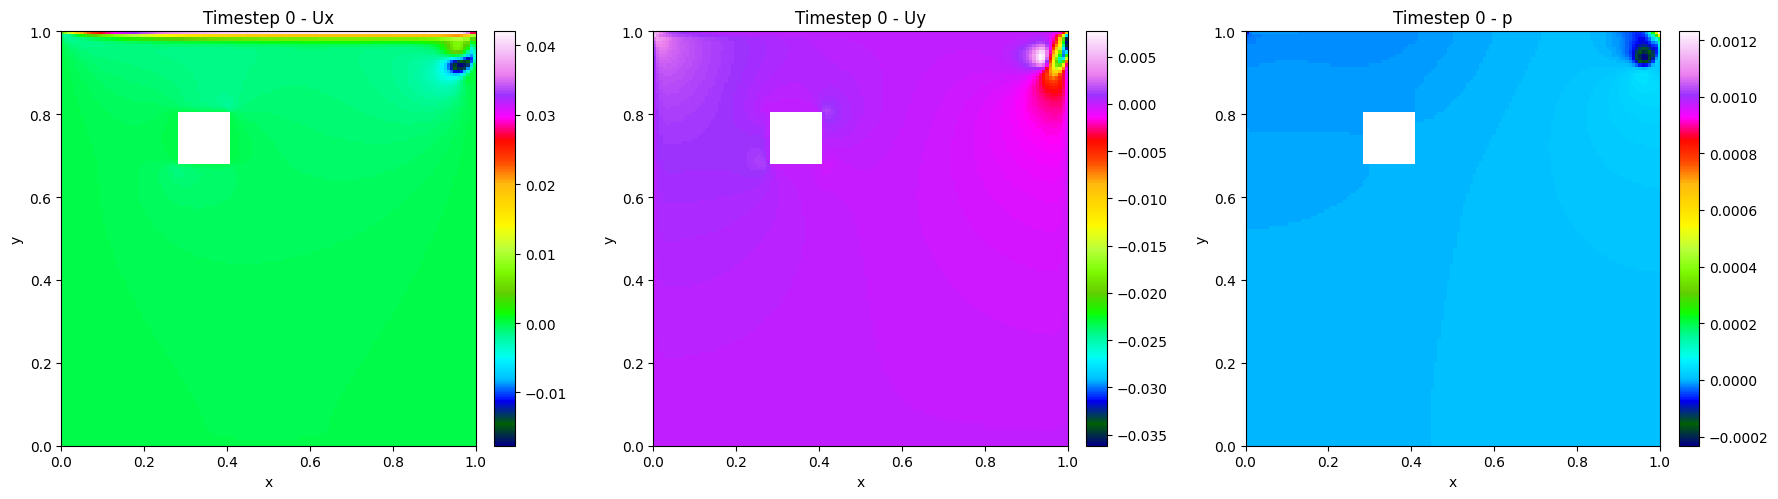

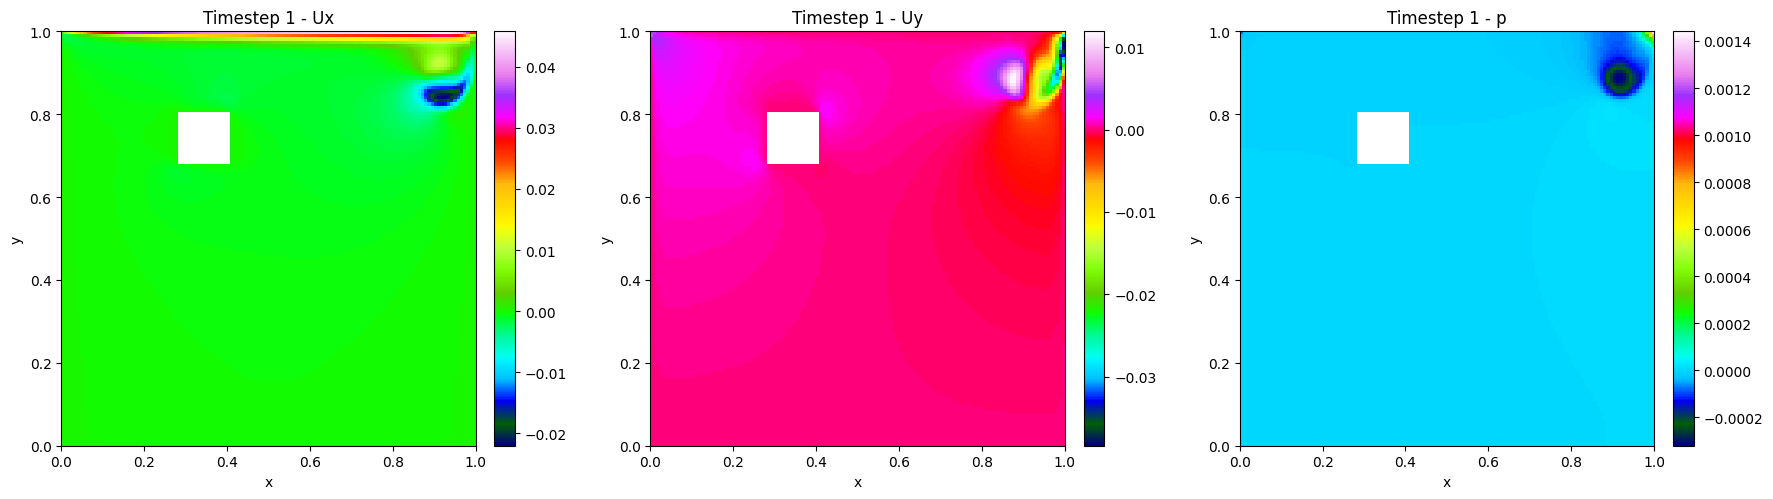

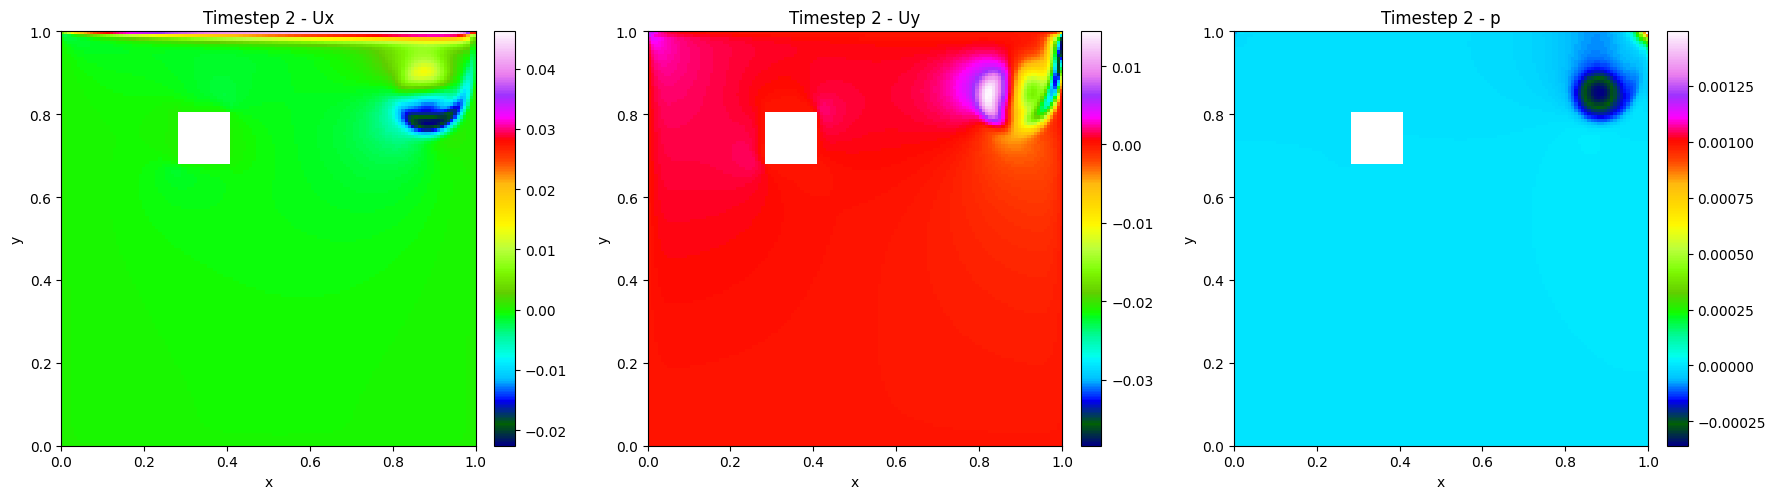

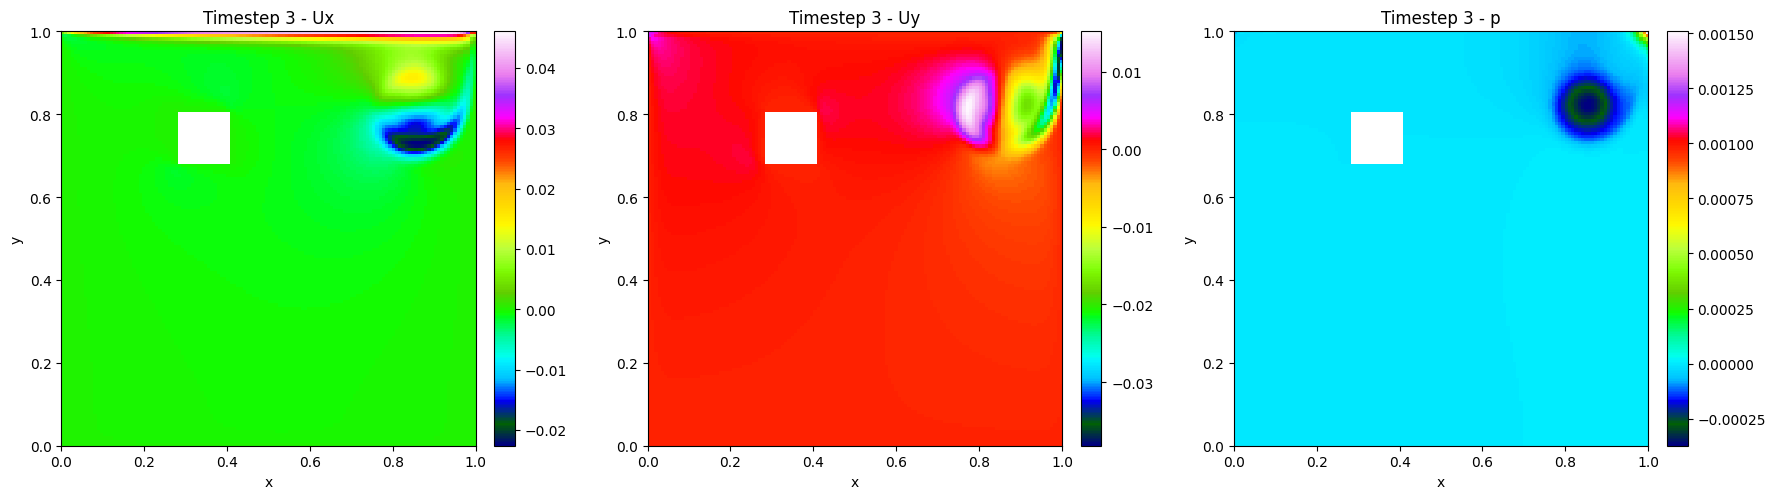

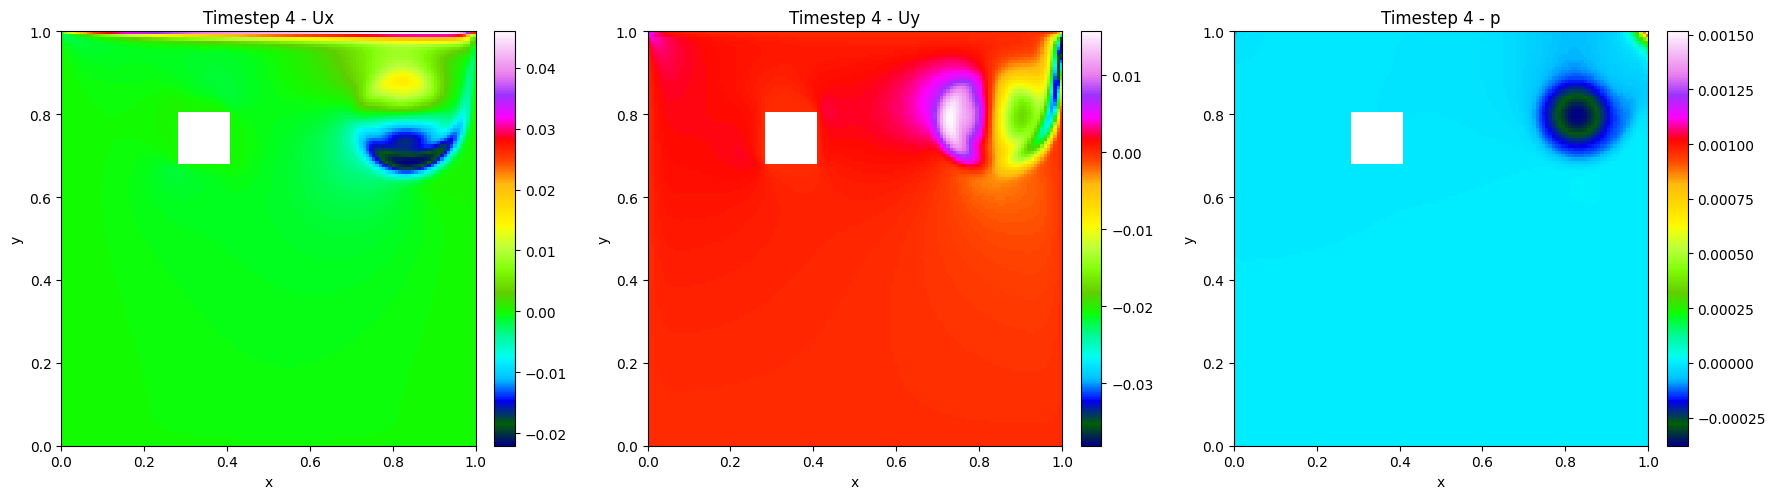

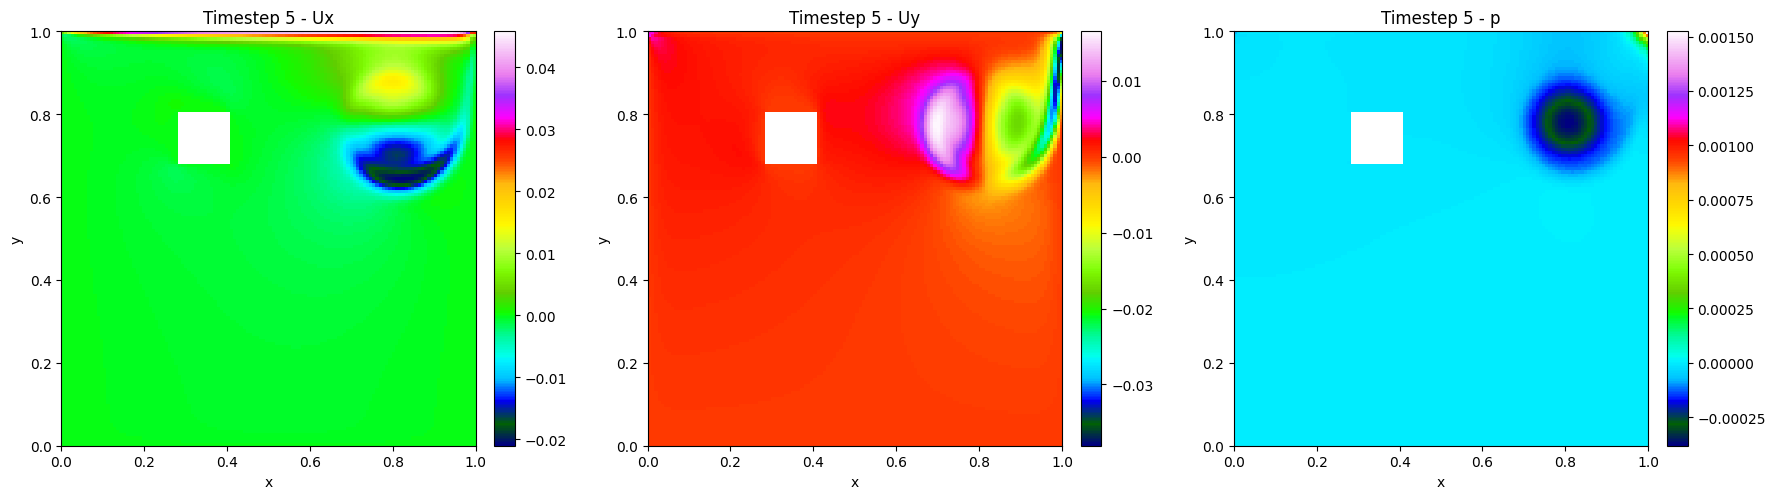

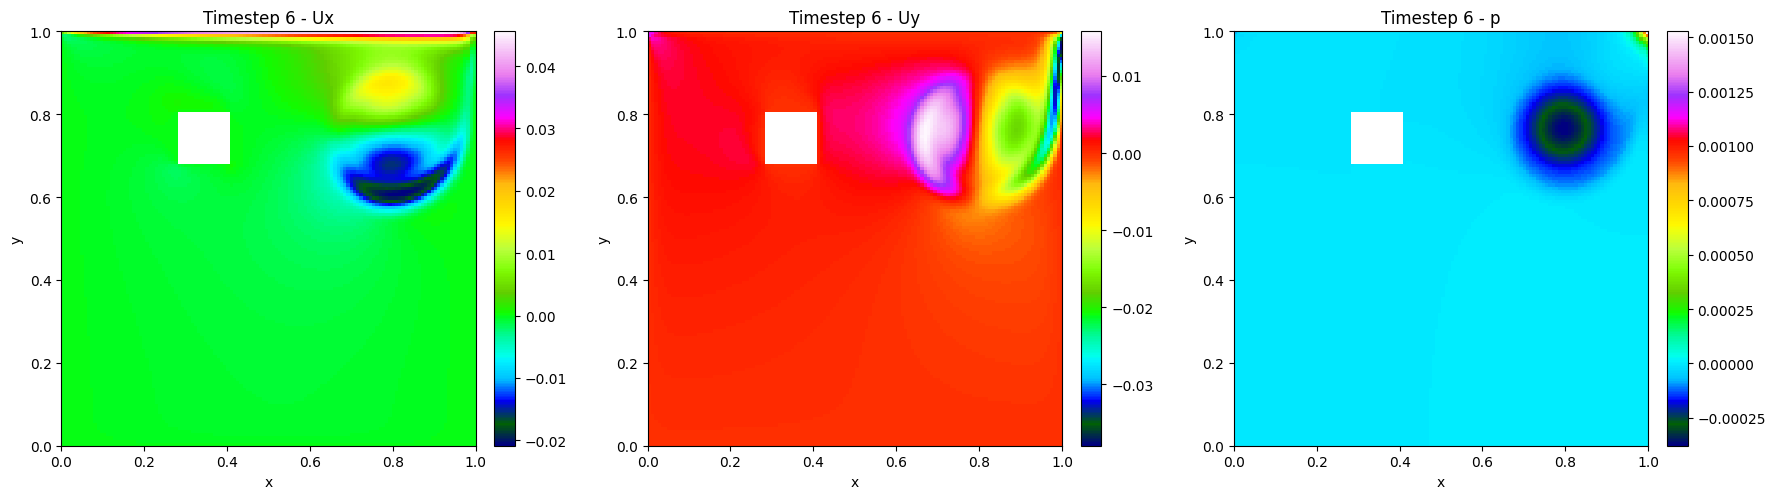

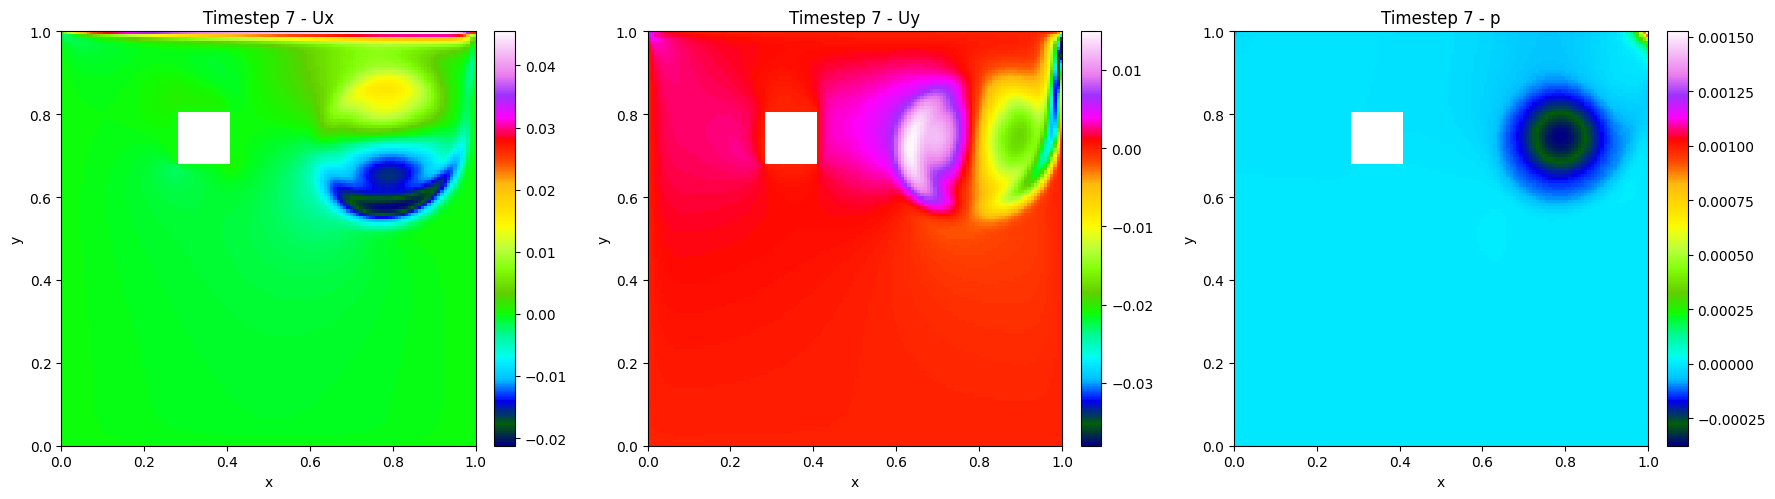

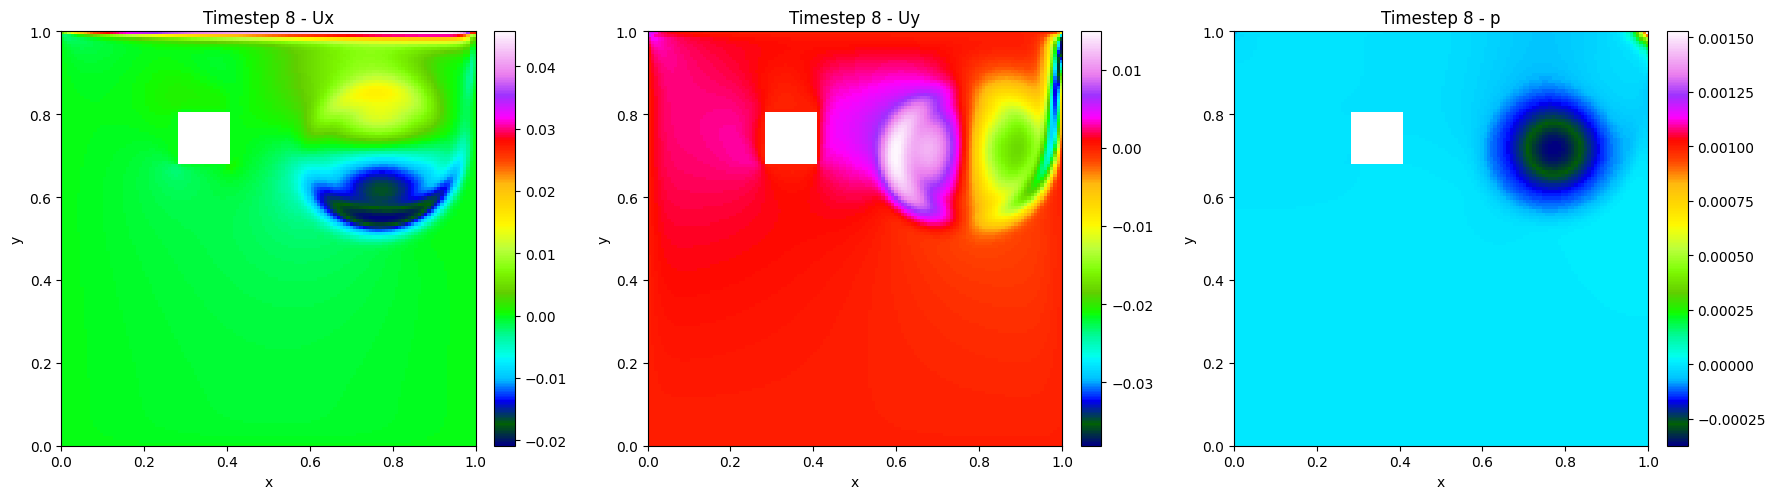

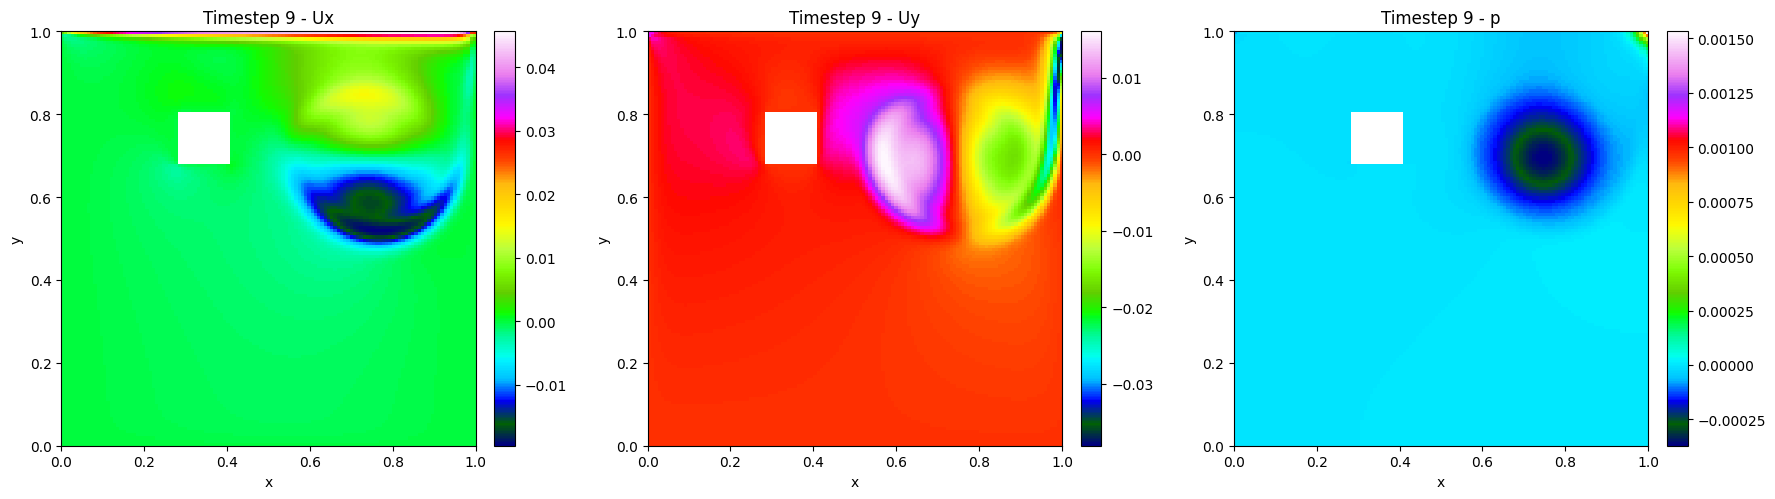

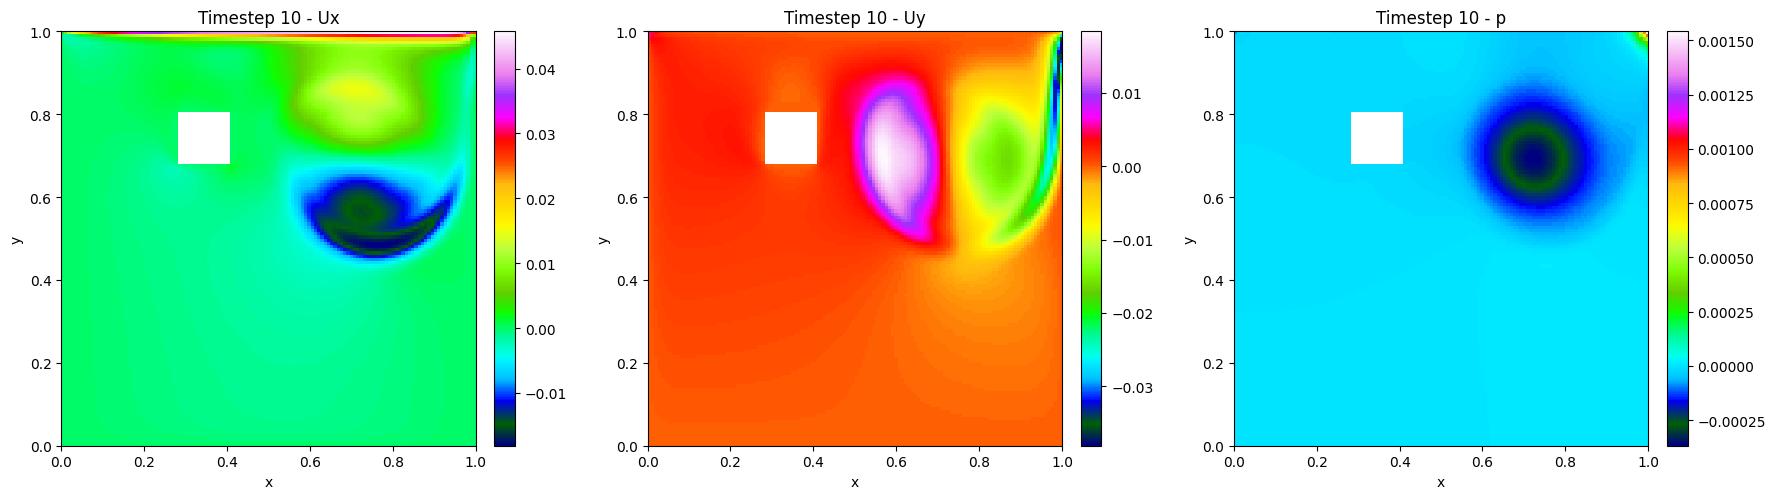

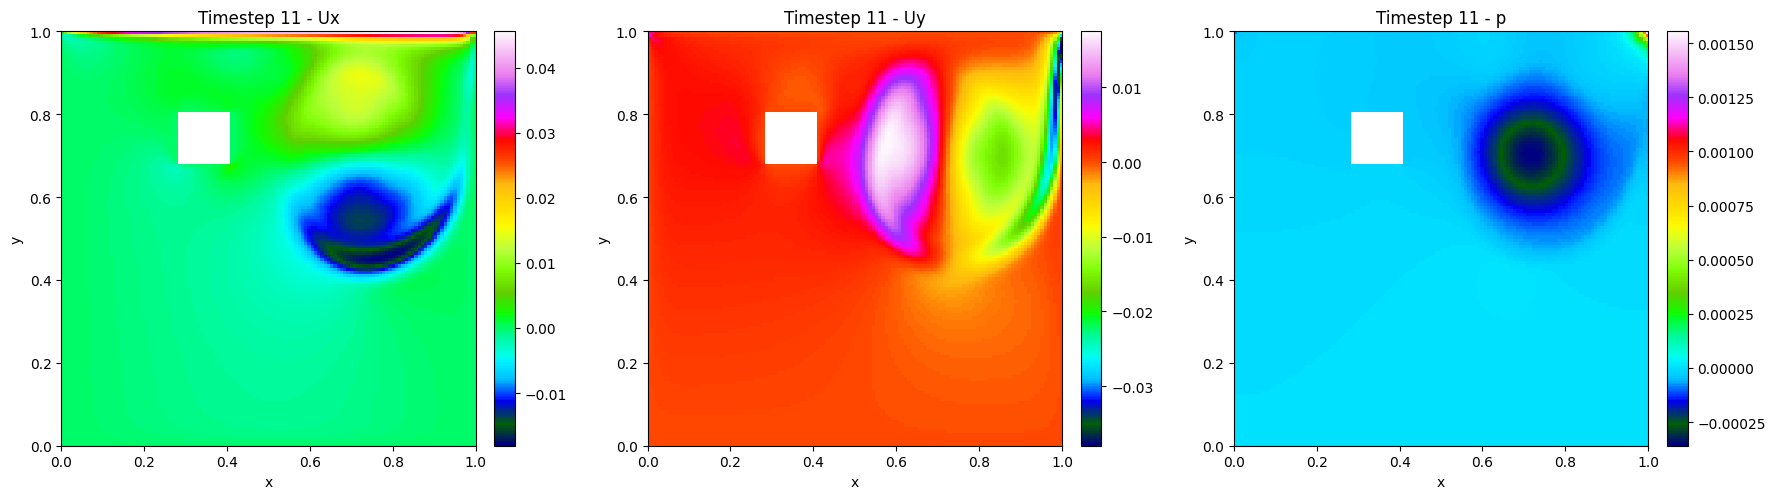

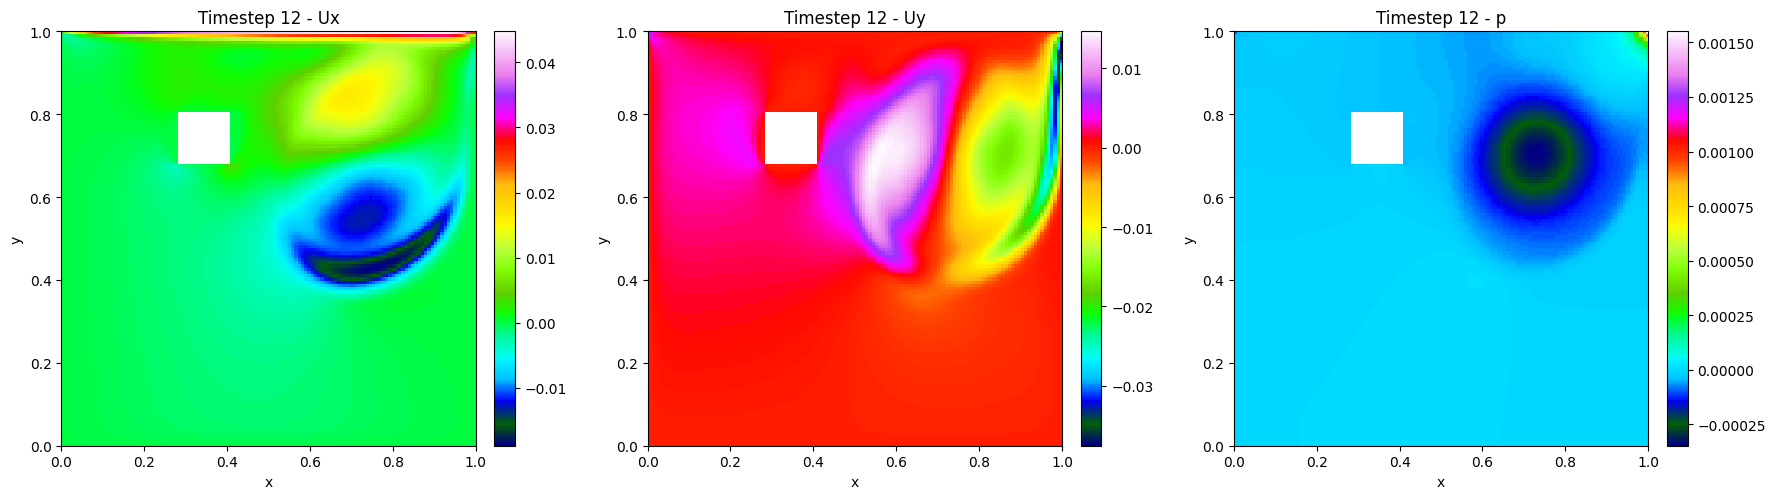

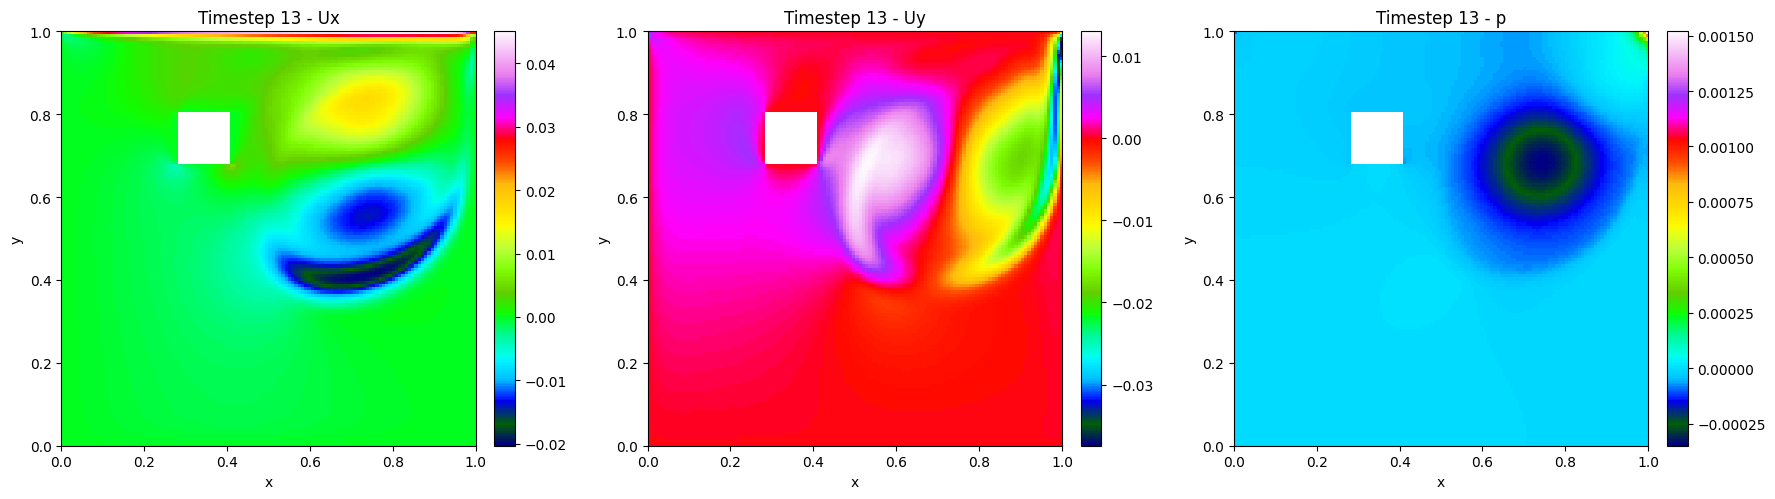

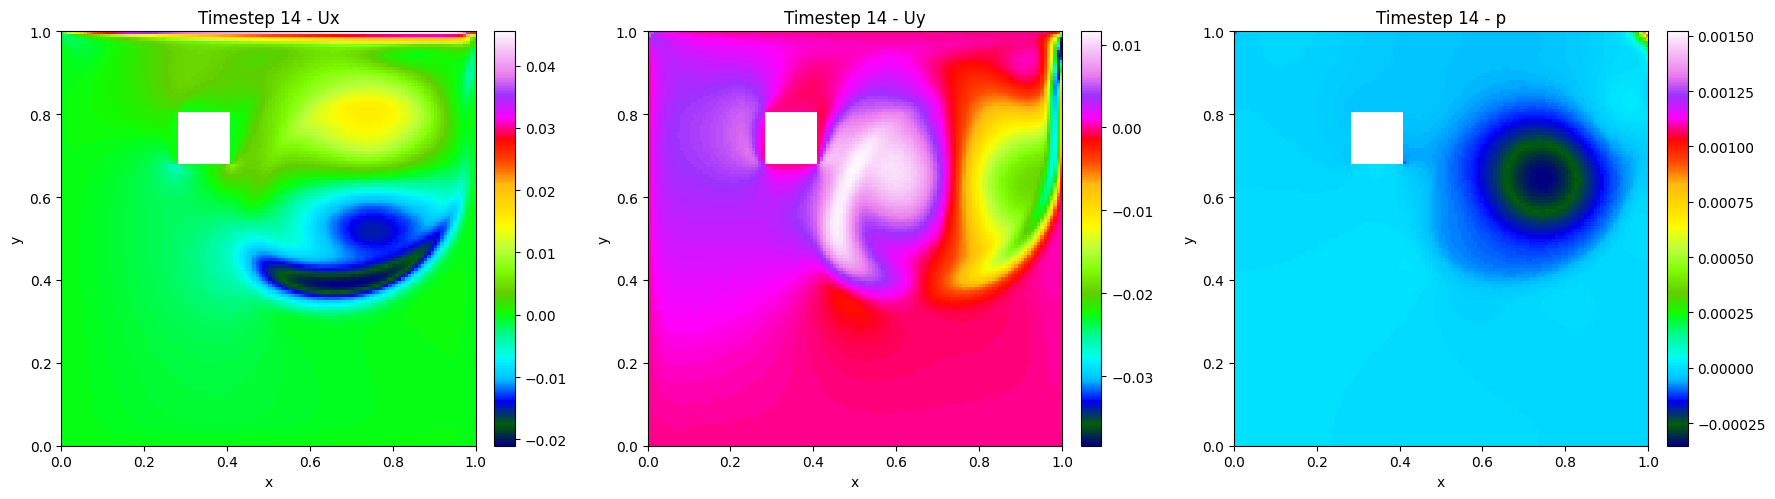

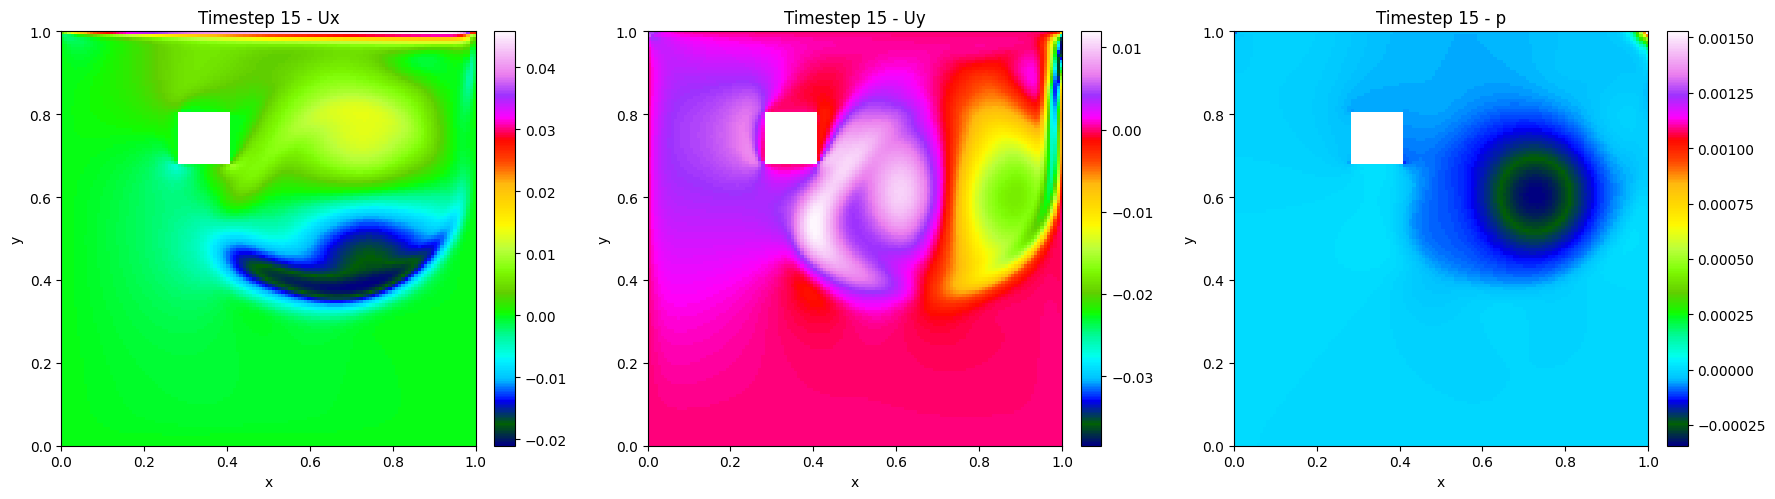

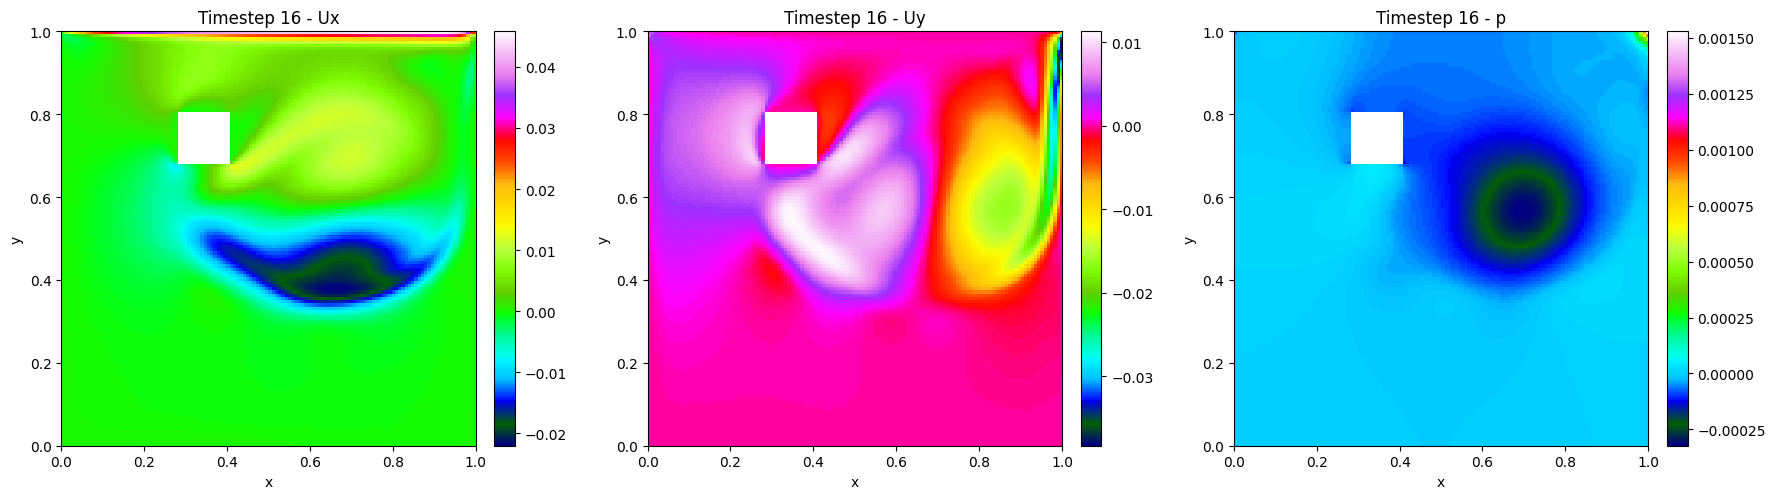

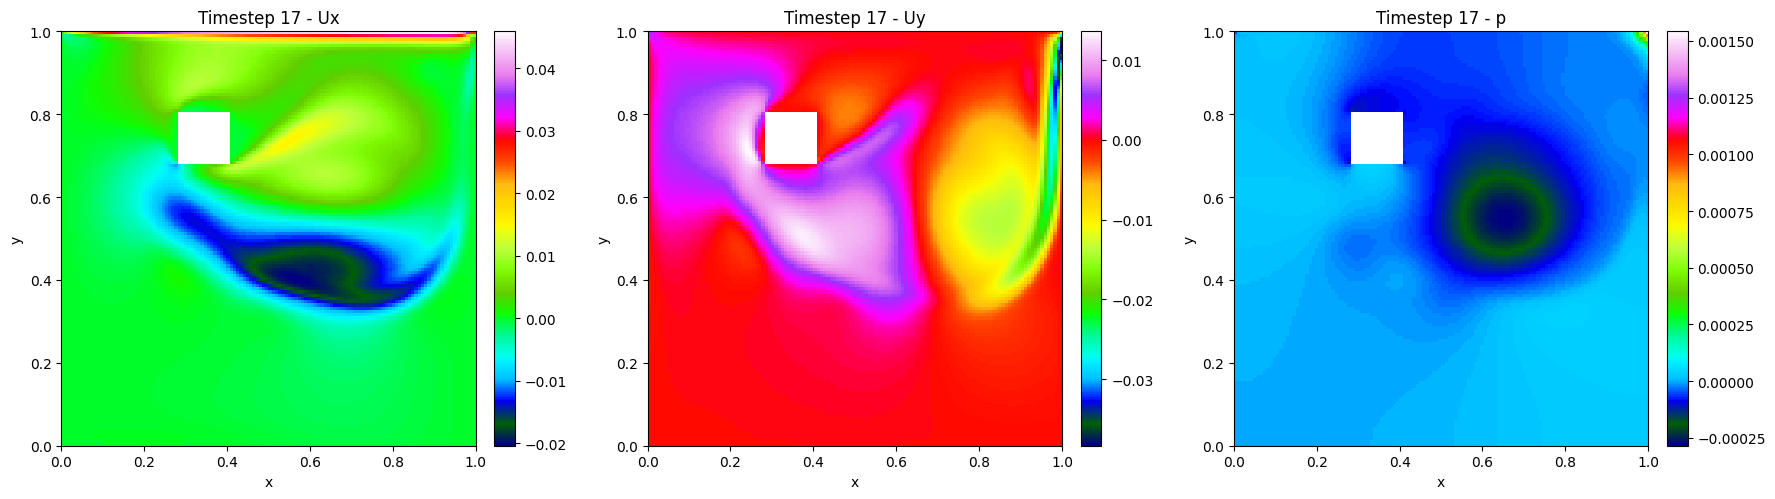

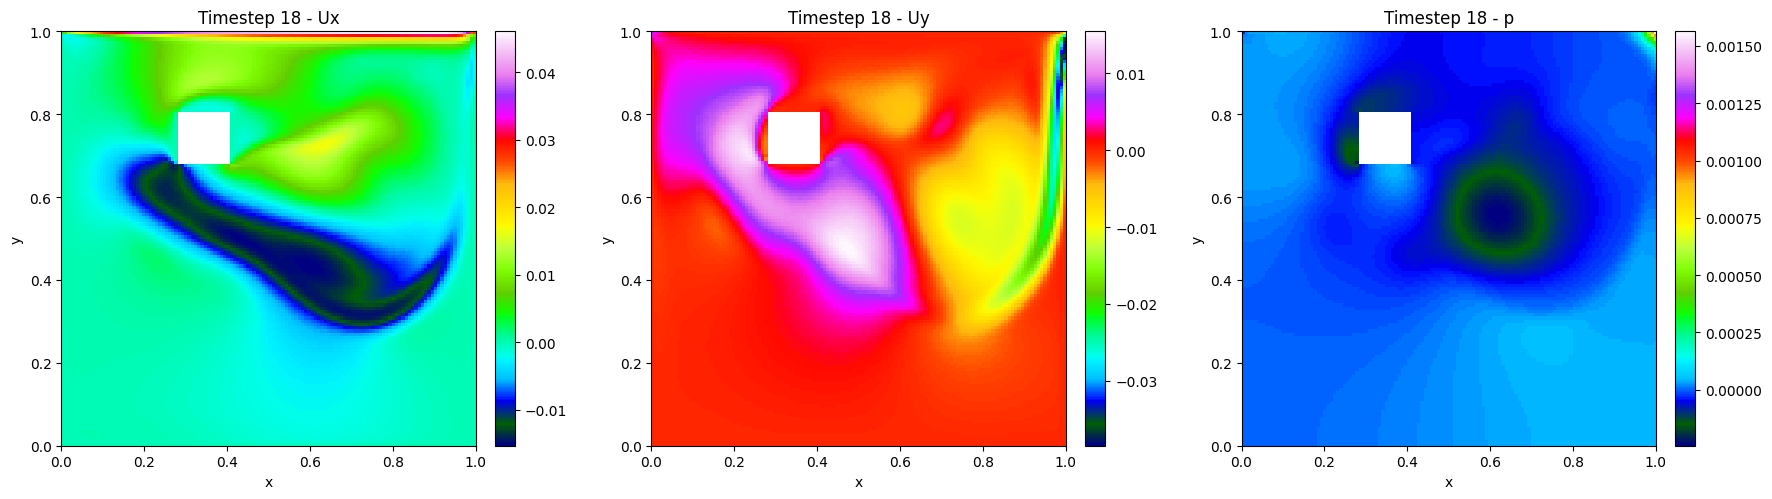

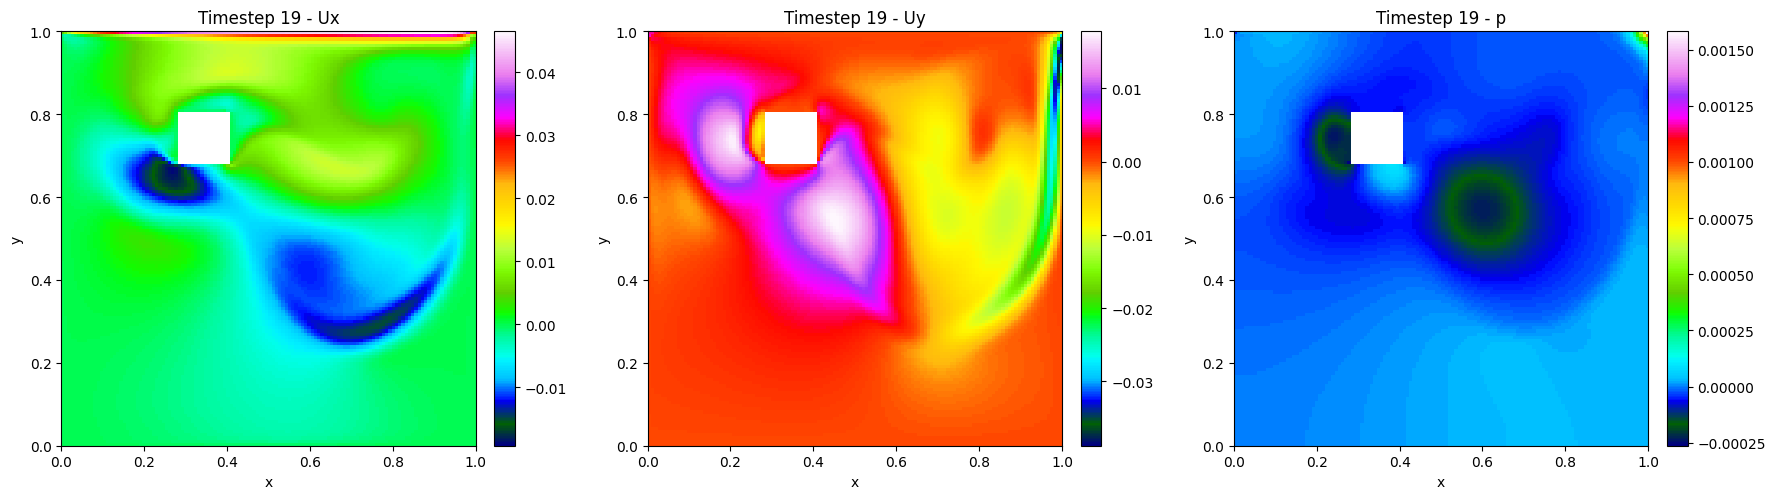

In [4]:
def visualize_dataset(data, trajectory_index=0):
    """
    Visualize all timesteps for the given trajectory while excluding hole cells.
    
    Data is assumed to have shape:
       (num_trajectories, timesteps, n_rows, n_cols, final_channels)
    where final_channels: 0=Ux, 1=Uy, 2=p, 3=hole indicator.
    
    This function displays Ux, Uy, and p for each timestep.
    """
    # Extract the trajectory to visualize
    traj_data = data[trajectory_index]  # shape: (timesteps, n_rows, n_cols, final_channels)
    timesteps, n_rows, n_cols, final_channels = traj_data.shape
    channel_names = ['Ux', 'Uy', 'p']
    
    for t in range(timesteps):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        for ch in range(3):
            field = traj_data[t, :, :, ch]
            mask = traj_data[t, :, :, 4]  # Hole indicator
            masked_field = np.ma.masked_where(mask == 1, field)  # Mask out hole cells
            
            ax = axs[ch]
            cmap = "gist_ncar" if ch in [0, 1] else "gist_ncar"
            im = ax.imshow(masked_field, cmap=cmap, origin='lower', extent=[0, 1, 0, 1])
            ax.set_title(f"Timestep {t} - {channel_names[ch]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

def main():
    # Load the reshaped dataset
    dataset = np.load("/data/user_data/namancho/LDC_hole_location/final_reshaped_data.npy")
    print("Dataset shape:", dataset.shape)
    
    # Visualize the first trajectory (or change trajectory_index as needed)
    visualize_dataset(dataset, trajectory_index=100)

if __name__ == "__main__":
    main()